# MSDS 7331 - Mini Lab: Logistic Regression and SVMs

### Investigators
- [Matt Baldree](mailto:mbaldree@smu.edu?subject=lab1)
- [Tom Elkins](telkins@smu.edu?subject=lab1)
- [Austin Kelly](ajkelly@smu.edu?subject=lab1)
- [Murali Parthasarathy](mparthasarathy@smu.edu?subject=lab1)


<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:5px;'>
    <h3>Lab Instructions</h3>
    <p>You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.
Write a report covering all the steps of the project. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the rendered iPython notebook. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.</p>
</div>

<a id='data_prep'></a>
## 1 - Data Preparation

In [1]:
#1.0.1 - Import the libraries we will need
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Read in the crime data from the Lab 1 CSV file
dc = pd.read_csv('data/DC_Crime_2015_Lab1.csv')

### *** TO DO:
###  * Incorporate a feature for the weather conditions during START_DATE and END_DATE so we can use rainfall/max temp/min temp in the regression
dc['REPORT_DAT'] = pd.to_datetime(dc['REPORT_DAT'])
dc=dc.rename(columns = {'REPORT_DAT':'REPORT_DATE'})
dc['START_DATE'] = pd.to_datetime(dc['START_DATE'])
dc['END_DATE'] = pd.to_datetime(dc['END_DATE'])
dc['XBLOCK'] = dc['XBLOCK'].astype(np.float64)
dc['YBLOCK'] = dc['YBLOCK'].astype(np.float64)
dc['Crime_Month'] = dc["END_DATE"].map(lambda x: x.month)
dc['Crime_WeekDay'] = dc["END_DATE"].map(lambda x:x.dayofweek)
dc['Crime_Weekend'] = dc["Crime_WeekDay"] >= 5
dc['Crime_Weekend'] = dc['Crime_Weekend'].astype(np.int64)

dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 29 columns):
REPORT_DATE             36489 non-null datetime64[ns]
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null datetime64[ns]
END_DATE                36489 non-null datetime64[ns]
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int6

In [2]:
print "---==< Crime Type vs Weekend >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Crime_Weekend)
print "---==< Crime Type vs Day of week >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Crime_WeekDay)
print "---==< Crime Type vs Month >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Crime_Month)
print "---==< Crime Type vs Shift >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.SHIFT)
print "---==< Crime Type vs District >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.DistrictID)
print "---==< Crime Type vs PSA >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.PSA_ID)
print "---==< Crime Type vs Ward >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.WARD)
print "---==< Crime Type vs ANC >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.ANC)
print "---==< Crime Type vs Neighborhood >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.NEIGHBORHOOD_CLUSTER)
print "---==< Crime Type vs Tract >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.CENSUS_TRACT)
print "---==< Crime Type vs Precinct >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.VOTING_PRECINCT)
print "---==< Crime Type vs Latitude >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Latitude)
print "---==< Crime Type vs Longitude >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Longitude)


---==< Crime Type vs Weekend >==---
Crime_Weekend      0     1
CRIME_TYPE                
1               4202  1971
2              21843  8473
---==< Crime Type vs Day of week >==---
Crime_WeekDay     0     1     2     3     4     5     6
CRIME_TYPE                                             
1               823   839   860   856   824  1000   971
2              4478  4270  4359  4172  4564  4350  4123
---==< Crime Type vs Month >==---
Crime_Month    1     2     3     4     5     6     7     8     9     10    11  \
CRIME_TYPE                                                                      
1             438   281   456   509   552   536   642   564   520   589   514   
2            2442  1592  2028  2426  2819  2875  3010  2903  2558  2630  2444   

Crime_Month    12  
CRIME_TYPE         
1             572  
2            2589  
---==< Crime Type vs Shift >==---
SHIFT         DAY  EVENING  MIDNIGHT
CRIME_TYPE                          
1            1244     2566      2363
2       

### 1.1 - Dataset Review
We continue to use our dataset selected for lab 1 - the 2015 Washington, D.C. Metro Crime data.  That dataset contained the type of crime committed (Field name "OFFENSE"; from which we derived an "Offense_Code" field and ascribed a numeric value for each offense type (NOTE: The number used does not imply a level of severity they were simply applied in order of appearance).  :

|Offense|Offense_Code|Crime_Type|
|:------|:----------:|---------:|
|Theft/Other|1|2 (Property)|
|Theft from Auto|2|2 (Property)|
|Burglary|3|2 (Property)|
|Assault with Dangerous Weapon|4|1 (Violent)|
|Robbery|5|1 (Violent)|
|Motor Vehicle Theft|6|2 (Property)|
|Homicide|7|1 (Violent)|
|Sex Abuse|8|1 (Violent)|
|Arson|9|2 (Property)|

The dataset contains a variety of geographic identifiers representing different political, social, and legal boundaries.

* DISTRICT -- the Police district within which the crime was committed
* Police Service Area (PSA) -- A subordinate area within a District
* Ward -- A political area, similar to a "county" in a larger state
* Advisory Neighborhood Committed (ANC) -- A subordinate area within a Ward
* Voting Precinct -- A political area for the management of voting residents
* Local Coordinates (XBLOCK and YBLOCK) -- location within the DC metro area based on the Maryland mapping system
* Global Coordinates (Latitude and Longitude) -- location on the planet

There are also time-based identifiers provided in the data
* The Start and End dates/times of when the crime *might* have been committed.
* The date/time the crime was reported (i.e. when the police responded and took the report)
* These can be further decomposed to Seasons, Months, Weeks, Day of the Week, etc.
* Shift - the police duty shift that responded to the crime (broken into 8-hour periods within a day)

From these time-based data we could associate environmental conditions as well, including temperatures, rainfall, phase of the moon, etc.

These features give us a variety of ways to attempt to classify the data.

### 1.2 - Classification Tasks
We decided to take a look at two different classification processes with our data set.

#### 1.2.1 - Crime_Type (Violent/Property)
The first classification task is a binary classification, in which we attempt to build a model to predict whether the crime will be against a person (violent) or against property given the other features of the data (geographic location, time of day, political area, etc.). The goal is to help the Police manage resources more appropriately.

#### 1.2.2 - Offense/Offense_Code
For the second classification task, we chose to attempt building a model to predict the type of offense (theft, homicide, assault, arson, etc.).  The hope is that if a type of crime could be predicted, then the Police would be better able to allocate offense-specific resources appropriately.

#### 1.2.3 - Model Comparison
Secondarily, we seek to compare the accuracy of the models - i.e. if the Crime_Type prediction indicates a "Violent" crime, does the Offense prediction agree (Homicide, Sex Abuse, Robbery, or Assault).


<a id="model_building"></a>
## 2 - Model Building

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>SVM and Logistic Regression Modeling</h3>
    <ol><li>[<b>50 points</b>] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.</li>
    <li>[<b>10 points</b>]  Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</li>
    <li>[<b>30 points</b>] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?</li>
    <li>[<b>10 points</b>]  Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.</li>
</ol>
</div>

### 2.1 - Logistic Regression Model for Crime_Type (Rubric Item 1)

In [3]:
# 2.1.1 Dataset creation

#  The field "CRIME_TYPE" exists as 1 = Violent, and 2 = Property.  
#  We subtract from 2 to make it 1 = Violent, and 0 = Property
LRM_Response = 2 - dc["CRIME_TYPE"]
#print LRM_Response

def RateModel(modelScore,meanResponse):
    print
    print "---==< Logistic Regression Results >==---"
    print
    print "Mean response for this data set is ", meanResponse
    print
    print "Model accuracy against this data set is ", modelScore
    print
    
    guessRate = 1.0 - meanResponse
    print "If we simply guessed 'Property' crime all the time, our accuracy would be ", guessRate
    print
    
    if modelScore > guessRate:
        print "The model predictions are better than simply guessing"
    elif modelScore == guessRate:
        print "The model predictions are the same as guessing"
    else:
        print "The model predictions are worse than simply guessing"
  

In [86]:
# 2.1.2 Model

#  Set up model using all location and time features
LRM_Features = dc[["PSA_ID","ANC","NEIGHBORHOOD_CLUSTER","CENSUS_TRACT","VOTING_PRECINCT","SHIFT_Code","Latitude","Longitude","Crime_Month","Crime_WeekDay","Crime_Weekend"]]
#print LRM_Features

#  Fit our model
LRM_Model = LogisticRegression()
LRM_Model.fit(LRM_Features, LRM_Response)

Predictions = LRM_Model.predict(LRM_Features)

#  How accurate is it?
Model_Acc = metrics.accuracy_score(LRM_Response,Predictions)
Model_Conf = metrics.confusion_matrix(LRM_Response,Predictions)
print Model_Conf
RateModel(Model_Acc,LRM_Response.mean())

[[29830   486]
 [ 5714   459]]

---==< Logistic Regression Results >==---

Mean response for this data set is  0.169174271698

Model accuracy against this data set is  0.830085779276

If we simply guessed 'Property' crime all the time, our accuracy would be  0.830825728302

The model predictions are worse than simply guessing


So - that was disappointing.  Let's see if the coefficients tell us anything

                       0                     1
0                 PSA_ID    [0.00167281742196]
1                    ANC     [0.0110371441361]
2   NEIGHBORHOOD_CLUSTER    [-0.0025635134189]
3           CENSUS_TRACT  [-1.48020338719e-05]
4        VOTING_PRECINCT    [0.00136857636899]
5             SHIFT_Code      [0.802727803558]
6               Latitude    [-0.0183006205069]
7              Longitude     [0.0485000031347]
8            Crime_Month    [0.00742452609029]
9          Crime_WeekDay     [0.0101210231365]
10         Crime_Weekend     [0.0350702378723]


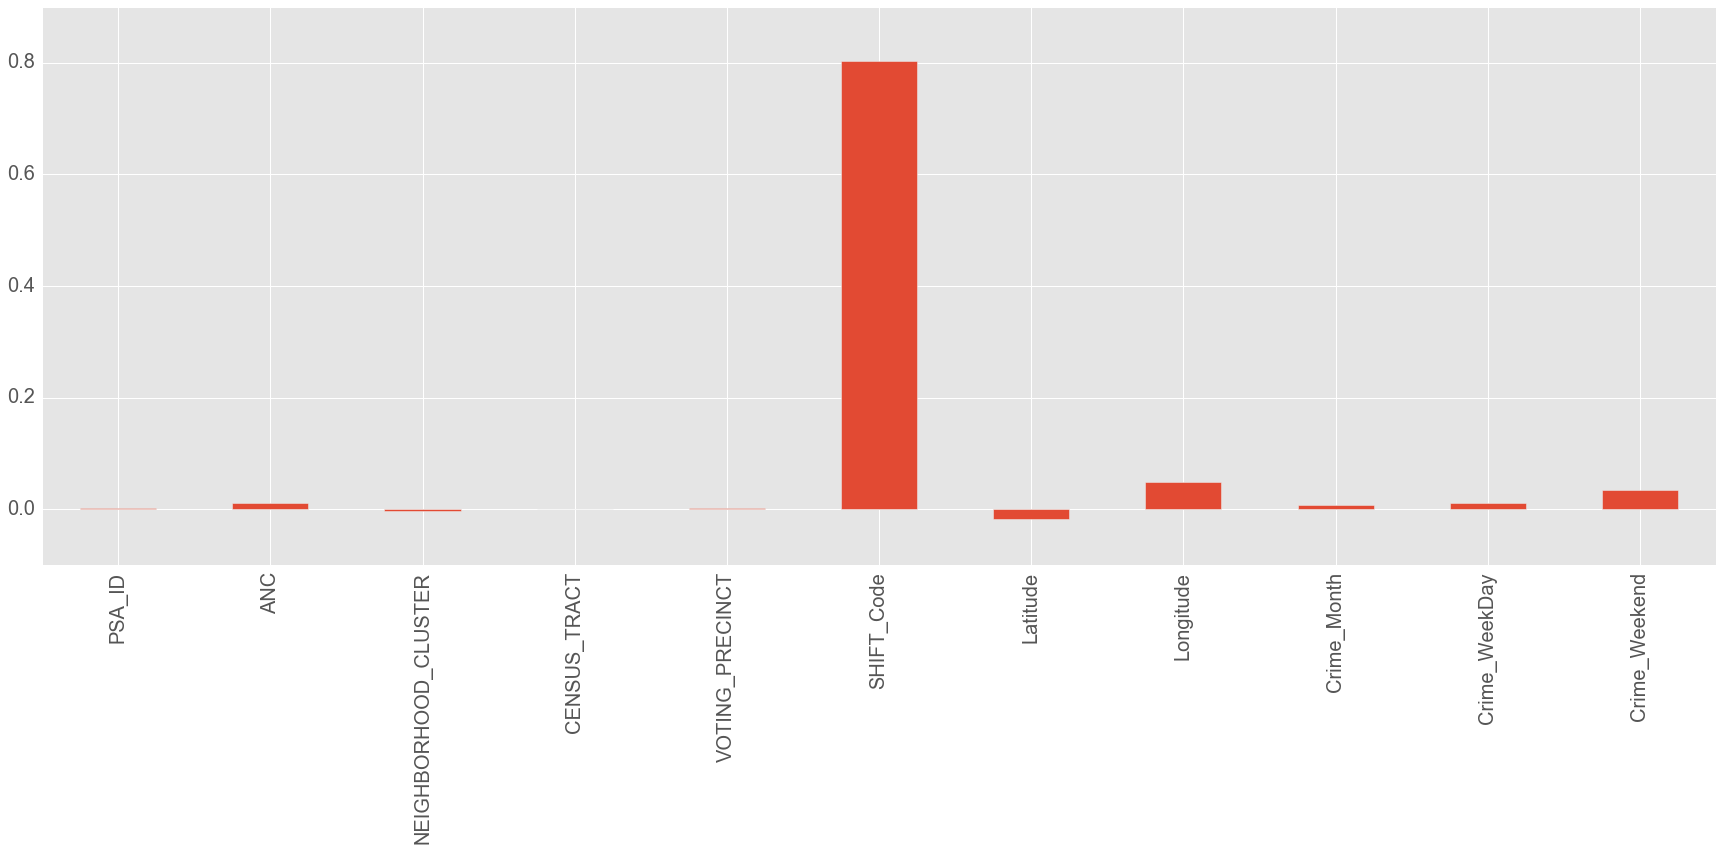

In [87]:
#2.1.3 Coefficients
#  Display the coefficients to see if they tell us anything
print pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)))

plt.figure(figsize=(30,10))
plt.style.use('ggplot')
weights = pd.Series(LRM_Model.coef_[0],index=LRM_Features.columns)
weights.plot(kind='bar')
plt.show()


* The SHIFT has the biggest impact (0.80) [by over an order of magnitude compared to all other features].  Each SHIFT value represents an 8-hour period in the day.
  * This suggests we should look at decreasing the period of time to smaller than 8 hours
* Longitude has the second-largest impact (0.0485).  The fact that it is positive implies that the odds of being a victim of a violent crime increases as we travel east (because longitude values in the western hemisphere are negative), holding all other factors constant.
* Weekends have the third-largest impact (0.035).
* Latitude has the fourth-largest impact (-0.018), implying that the odds of being a victim of a violent crime increases as we travel south.

The factors with the smallest magnitude coefficients were all location based:
* CENSUS_TRACT = 0 (effectively)
* VOTING_PRECINCT = 0.0013
* Police Service Area = 0.0016 (I believe this implies that the Police are equally effective in all of their service areas)
* NEIGHBOORHOOD_CLUSTER = -0.0026

This points to removing some of the location factors, and increasing the resolution in time factors to less than 8-hour periods.

Ah - but first we need to normalize the factors to get a better feel for their impacts

[[5945   56]
 [1208   89]]

---==< Logistic Regression Results >==---

Mean response for this data set is  0.177719923267

Model accuracy against this data set is  0.826801863524

If we simply guessed 'Property' crime all the time, our accuracy would be  0.822280076733

The model predictions are better than simply guessing

---==< Coefficients in descending order of magnitude >==---
                  Factor         Coefficient
5             SHIFT_Code    [0.579225987645]
0                 PSA_ID    [0.284614206836]
1                    ANC    [0.223216833542]
7              Longitude    [0.190247018239]
3           CENSUS_TRACT   [-0.105946997593]
2   NEIGHBORHOOD_CLUSTER  [-0.0776911449924]
8            Crime_Month    [0.036498631728]
6               Latitude   [-0.035379293964]
10         Crime_Weekend   [0.0223786593569]
9          Crime_WeekDay   [0.0223136565755]
4        VOTING_PRECINCT   [0.0201762545948]


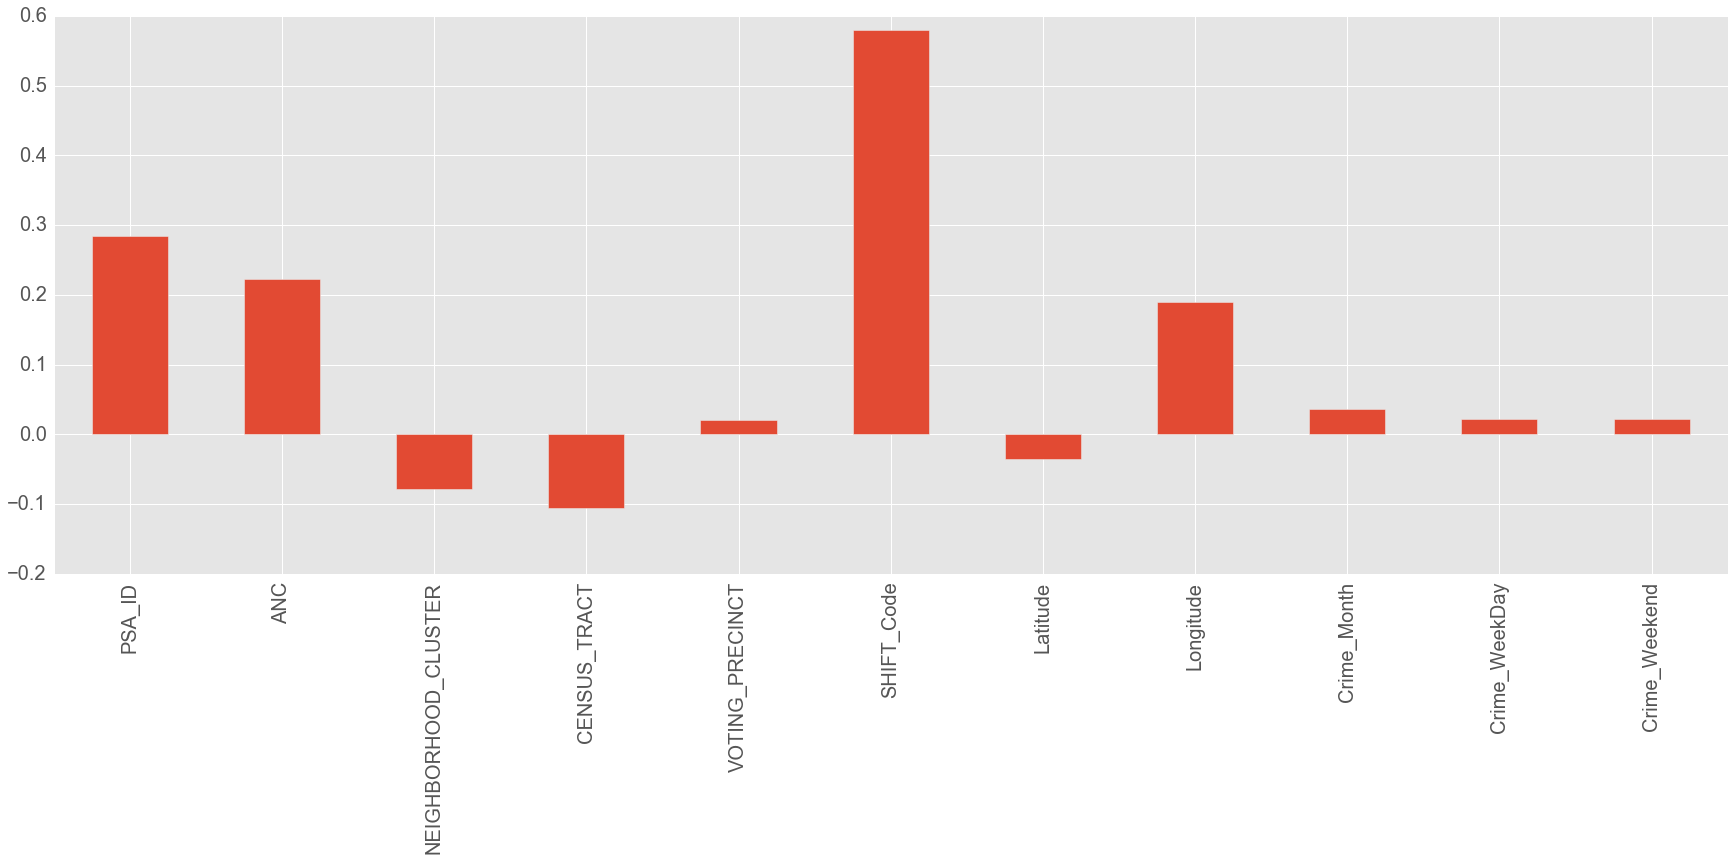

In [88]:
#2.1.4 - Split into training and test sets (80/20)
LRM_XTrain, LRM_XTest, LRM_YTrain, LRM_YTest = train_test_split(LRM_Features, LRM_Response, test_size=0.2, random_state=0)

#2.1.5 - Feature normalization  (From class notebook #4)
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
Scaler.fit(LRM_XTrain)

# Now we transform our data based on the scaler
Scaled_XTrain = Scaler.transform(LRM_XTrain)
Scaled_XTest = Scaler.transform(LRM_XTest)

# Fit the model against the scaled training data
LRM_Model.fit(Scaled_XTrain,LRM_YTrain)

# Generate predictions on the test set
Predictions2 = LRM_Model.predict(Scaled_XTest)

Model_Acc2 = metrics.accuracy_score(LRM_YTest,Predictions2)
Model_Conf2 = metrics.confusion_matrix(LRM_YTest,Predictions2)
print Model_Conf2
RateModel(Model_Acc2,LRM_YTest.mean())

pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)))
coefs = pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)), columns=['Factor','Coefficient'])
print
print "---==< Coefficients in descending order of magnitude >==---"
print coefs.reindex(coefs.Coefficient.abs().sort_values(ascending=False).index)

plt.figure(figsize=(30,10))
plt.style.use('ggplot')
weights = pd.Series(LRM_Model.coef_[0],index=LRM_Features.columns)
weights.plot(kind='bar')
plt.show()


Now, with normalized coefficients, we see that:

* The SHIFT still has the biggest impact (0.58), but not as much as it had unscaled.  Each SHIFT value represents an 8-hour period in the day.
  * This still suggests we should look at decreasing the period of time to smaller than 8 hours
* Day of the week, Weekends, and Month have dropped in impact, and location-based factors have increased in importance
* Police Service Areas have the second-largest impact (0.28).
* Advisory Neighborhood Commissions have the third-largest impact.

**Other trends of note**:
* Longitude still has a substantial coefficient, implying that one's location is still important.
* One's odds of being the victim of a violent crime is greater on the weekends than during the week (holding all other factors constant).
* The day of the week has a positive coefficient, implying that one's odds of being the victim of a violent crime increases as the week progresses [Weekdays are numbered 0=Monday ... 6=Sunday] (holding all other factors constant). This coincides with the odds increasing on the weekends versus a weekday.

**Cautions**:
* Shift, PSA, ANC, and Day of the week are categorical, not ordinal, so we need to one-hot encode these features to get more resolution on *how* they impact the odds of being a victim of violent crime.
* This will **drastically** increase the number of explanatory variables.

In [89]:
#2.1.6 Feature adjustments

#  Extract the hour of the day from the END_DATE field.  Use this instead of SHIFT to get better resolution
dc['Crime_Hour'] = dc["END_DATE"].map(lambda x:x.hour)
tmp_df = pd.get_dummies(dc.Crime_Hour,prefix="Hour")
dc_expanded = pd.concat((dc,tmp_df),axis=1)

#  Create fields for each Police Service Area (correlated with District)
tmp_df = pd.get_dummies(dc.PSA_ID,prefix='PSA')
dc_expanded = pd.concat((dc_expanded,tmp_df),axis=1)

#  Create fields for each Association Neighborhood Commission (correlated with Ward)
tmp_df = pd.get_dummies(dc.ANC,prefix='ANC')
dc_expanded = pd.concat((dc_expanded,tmp_df),axis=1)

#  Create fields for each Month (to give us seasonal/monthly insights)
tmp_df = pd.get_dummies(dc.Crime_Month,prefix='Month')
dc_expanded = pd.concat((dc_expanded,tmp_df),axis=1)


#2.1.7 - Remove unnecessary columns
if 'REPORT_DATE' in dc_expanded:
    del dc_expanded['REPORT_DATE']  #  Too specific for use
if 'SHIFT' in dc_expanded:
    del dc_expanded['SHIFT']   #  The Crime_Hour dummies take care of this
if 'OFFENSE' in dc_expanded:
    del dc_expanded['OFFENSE']  # One of the response variables
if 'METHOD' in dc_expanded:
    del dc_expanded['METHOD']   # Related to OFFENSE
if 'DISTRICT' in dc_expanded:
    del dc_expanded['DISTRICT']  #  The PSA dummies take care of this
if 'PSA' in dc_expanded:
    del dc_expanded['PSA']   # We have dummies for each PSA
if 'WARD' in dc_expanded:
    del dc_expanded['WARD']  # The ANC dummies take care of this
if 'ANC' in dc_expanded:
    del dc_expanded['ANC']   # We now have dummies for each ANC
if 'NEIGHBORHOOD_CLUSTER' in dc_expanded:
    del dc_expanded['NEIGHBORHOOD_CLUSTER']  #  Removed because ANC *should* take care of this
if 'CENSUS_TRACT' in dc_expanded:
    del dc_expanded['CENSUS_TRACT']  #  Removed because ANC *should* take care of this
if 'VOTING_PRECINCT' in dc_expanded:
    del dc_expanded['VOTING_PRECINCT']  #  Removed because ANC *should* take care of this
if 'CCN' in dc_expanded:
    del dc_expanded['CCN']  #  Unique to each report
if 'XBLOCK' in dc_expanded:
    del dc_expanded['XBLOCK']  # Handled by Longitude
if 'YBLOCK' in dc_expanded:
    del dc_expanded['YBLOCK']  # Handled by Latitude
if 'START_DATE' in dc_expanded:
    del dc_expanded['START_DATE']  # Part of a range of dates and too specific for use
if 'END_DATE' in dc_expanded:
    del dc_expanded['END_DATE']  # Day of week, Month, and Hour are all derived from this field
if 'DistrictID' in dc_expanded:
    del dc_expanded['DistrictID'] # We can derive the District from the PSA
if 'PSA_ID' in dc_expanded:
    del dc_expanded['PSA_ID'] # We now have dummies for each PSA
if 'SHIFT_Code' in dc_expanded:
    del dc_expanded['SHIFT_Code'] # We now have hours
if 'OFFENSE_Code' in dc_expanded:
    del dc_expanded['OFFENSE_Code']  # One of the response variables
if 'METHOD_Code' in dc_expanded:
    del dc_expanded['METHOD_Code']  # Related to OFFENSE_Code
if 'AGE' in dc_expanded:
    del dc_expanded['AGE']  #  Not a predictor - related to the range of times for the crime
if 'TIME_TO_REPORT' in dc_expanded:
    del dc_expanded['TIME_TO_REPORT']  # Not a predictor - related to the response time
if 'Crime_Hour' in dc_expanded:
    del dc_expanded['Crime_Hour']  # We now have dummies for each hour
if 'Crime_WeekDay' in dc_expanded:
    del dc_expanded['Crime_WeekDay'] #  Impact was less than the Weekend flag
if 'Crime_Month' in dc_expanded:
    del dc_expanded['Crime_Month'] # We now have dummies for each month
if 'CRIME_TYPE' in dc_expanded:
    del dc_expanded['CRIME_TYPE'] # Our response variable, because it exists in LRM_Response still

#2.1.8 - Split into training and test sets (80/20)
LRM_XTrain3, LRM_XTest3, LRM_YTrain3, LRM_YTest3 = train_test_split(dc_expanded, LRM_Response, test_size=0.2, random_state=0)

Scaler.fit(LRM_XTrain3)

# Now we transform our data based on the scaler
Scaled_XTrain3 = Scaler.transform(LRM_XTrain3)
Scaled_XTest3 = Scaler.transform(LRM_XTest3)

# Fit the model against the scaled training data
LRM_Model.fit(Scaled_XTrain3,LRM_YTrain3)

# Generate predictions on the test set
Predictions3 = LRM_Model.predict(Scaled_XTest3)

Model_Acc3 = metrics.accuracy_score(LRM_YTest3,Predictions3)
Model_Conf3 = metrics.confusion_matrix(LRM_YTest3,Predictions3)
print Model_Conf3
RateModel(Model_Acc3,LRM_YTest3.mean())


[[5889  112]
 [1154  143]]

---==< Logistic Regression Results >==---

Mean response for this data set is  0.177719923267

Model accuracy against this data set is  0.82652781584

If we simply guessed 'Property' crime all the time, our accuracy would be  0.822280076733

The model predictions are better than simply guessing


---==< Coefficients in descending order >==---
        Factor         Coefficient        Odds_Ratio
91      ANC_25    [0.283746968269]   [1.32809683759]
121     ANC_84     [0.22554504914]   [1.25300547966]
3       Hour_0      [0.2016816469]   [1.22345845432]
122     ANC_85    [0.200448628732]   [1.22195083746]
26     Hour_23    [0.188550654034]   [1.20749824609]
120     ANC_83     [0.18366621755]   [1.20161467826]
118     ANC_81    [0.177383632859]   [1.19408909708]
119     ANC_82    [0.173793590893]   [1.18980995286]
5       Hour_2    [0.172916116102]   [1.18876638254]
4       Hour_1    [0.170401648763]   [1.18578102317]
1    Longitude    [0.160261954145]    [1.1738183173]
25     Hour_22    [0.160217615807]    [1.1737662733]
24     Hour_21    [0.157136253156]   [1.17015504036]
66     PSA_507    [0.149976319892]   [1.16180673069]
6       Hour_3    [0.146095230055]   [1.15730639315]
64     PSA_505    [0.134042217456]    [1.1434410918]
117     ANC_76    [0.133864283074]   [1.14323765242]

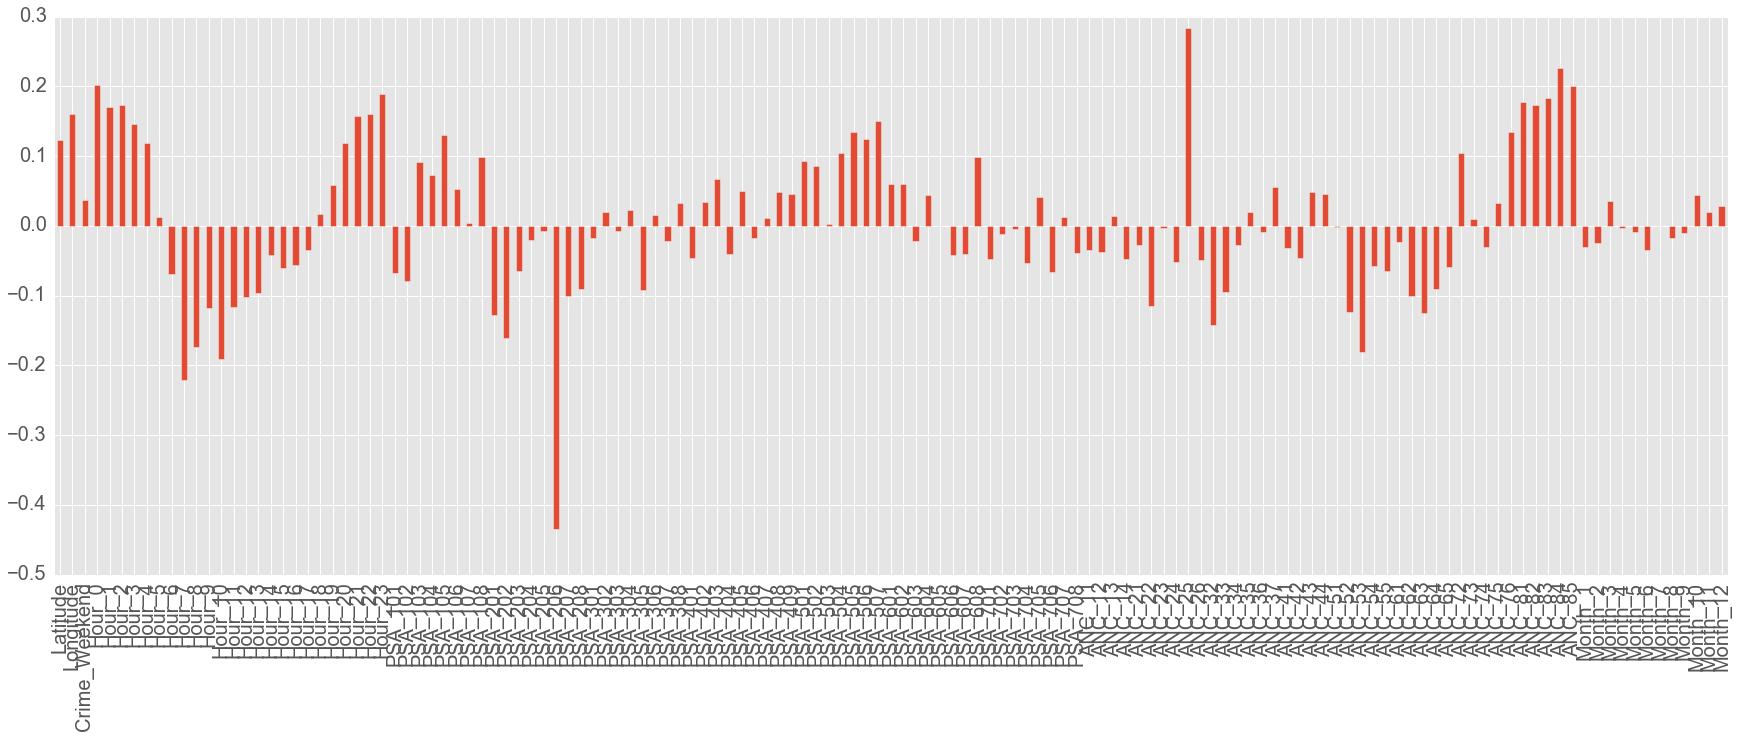

In [90]:
#2.1.9
#  Display the coefficients to see if they tell us anything
coefs = pd.DataFrame(zip(dc_expanded.columns, np.transpose(LRM_Model.coef_)), columns=['Factor','Coefficient'])
coefs['Odds_Ratio'] = coefs.Coefficient.map(lambda x: np.exp(x))

print "---==< Coefficients in descending order >==---"
#print coefs.reindex(coefs.Coefficient.abs().sort_values(ascending=False).index)
print coefs.reindex(coefs.Coefficient.sort_values(ascending=False).index)

plt.figure(figsize=(30,10))
plt.style.use('ggplot')
weights = pd.Series(LRM_Model.coef_[0],index=dc_expanded.columns)
weights.plot(kind='bar')
plt.show()


In [106]:
#coefs[83:123] = ANC

print coefs.reindex(coefs[:3].Coefficient.sort_values(ascending=False).index)

          Factor        Coefficient       Odds_Ratio
1      Longitude   [0.160261954145]   [1.1738183173]
0       Latitude   [0.122611339833]  [1.13044497662]
2  Crime_Weekend  [0.0365307979585]  [1.03720624736]


#### 2.1.10 - Interpretation of the Coefficients (RUBRIC ITEM 3)
There are some interesting items highlighted in the coefficients that might prove helpful for the police departments.

##### 2.1.10.1 - Advisory Neighborhood Commissions
* It was very interesting to see the distribution of violent crimes across the ANCs.  It was difficult to envision based on the identifiers, so we needed to plot them geographically.
  * The way we encoded the data for ANC (by converting the terminal letter to its ordinal position in the alphabet) allowed us to reassociate the numeric ANC back to its geographic identifier.
  * NOTE: The ANC with the highest odds ratio (2E @ 1.33) is a direct neighbor to one of the lowest odds ratio (3B @ 0.87).
![Violent ANC Map](images/anc_violent.png "Violent ANC")
<p style='text-align: center;'>
Odds Ratios for violent crimes by ANC
</p>

##### 2.1.10.2 - Geographic Location
* Note also that Latitude and Longitude have fairly large odds ratios as well (Latitude: 1.130, Longitude: 1.174).  The latitude coefficient implies that the odds of becoming a victim of a violent crime increases as one heads north - this is counter to what we see with the ANC distribution.
* Longitude values are negative in the Western Hemisphere, so an increase in longitude is equivalent to traveling east; thus, the positive coefficient implies that the odds increase as one travels east.  This, too, is counter to what we see with the ANC distribution.

##### 2.1.10.3 - Day of the Week/Weekend
* The original regression attempt showed us that the day of the week was not a significant factor - the coefficient for all days showed a trend of increasing as the week progressed through the weekend, and was slightly lower than the coefficient for a violent crime occurring on the weekend.  Thus, we removed the days of the week from consideration, but kept the weekend indicator variable.
* The coefficient (0.0365307979585) gives us an odds ratio of $e^{0.0365307979585}$ = 1.03720624736, indicating a slightly higher chance of becoming a victim of a violent crime on the weekends as opposed to during the work week.

##### 2.1.10.4 - Hour of the Day
* There is an interesting cyclic trend with the hour of the day that implies that from 6PM to 6AM, one's odds of being a victim of a violent crime are greater than during the period from 6AM to 6PM.
  * This trend spans two Police duty shifts (Evening shift is 3PM to 11PM, Midnight shift is 11PM to 7AM, and Day shift is 7AM to 3PM) 
  * Re-combining the hours into a binary Day/Night variable might be another good decision tree split point.

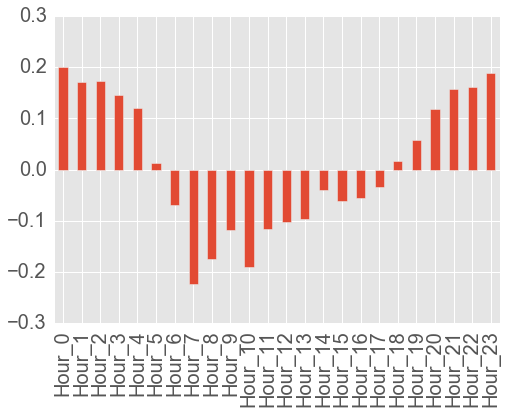

In [26]:
weights[3:27].plot(kind='bar')
plt.show()

##### 2.1.10.5 - Month of the Year
* We were also interested in seeing if there was a seasonal trend, but the coefficients seem to imply nearly the opposite of what we expected.
  * This (and our own curiosity) is what is pushing us to explore the weather data for these crimes

       Factor           Coefficient        Odds_Ratio
131   Month_1    [-0.0306923203701]  [0.969773906855]
132   Month_2    [-0.0238244187156]  [0.976457142306]
133   Month_3     [0.0357981324326]   [1.03644660042]
134   Month_4   [-0.00287849307963]  [0.997125645809]
135   Month_5   [-0.00942154045299]  [0.990622703202]
136   Month_6    [-0.0347550641734]  [0.965841956586]
137   Month_7  [-0.000290206492594]  [0.999709835613]
138   Month_8    [-0.0175716574527]  [0.982581823832]
139   Month_9   [-0.00993691094781]  [0.990112297025]
140  Month_10     [0.0443499794159]   [1.04534814121]
141  Month_11     [0.0199982551742]   [1.02019955995]
142  Month_12     [0.0290779550565]   [1.02950484646]


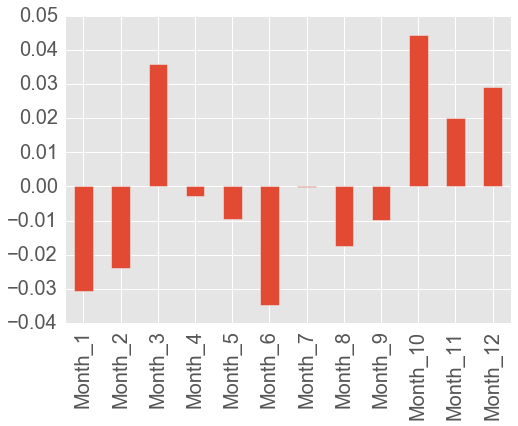

In [29]:
print coefs[131:]
weights[131:].plot(kind='bar')
plt.show()

#### 2.1.11 - Dimension Reduction (RUBRIC ITEM - EXCEPTIONAL)

Attempting to use a 135-factor model is simply not practical for the modest improvement in accuracy over simple guessing.  To address this, we decided to perform principal components analysis to attempt to reduce the dimensionality to something more manageable, but less interpretable.

In [107]:
# 2.1.11.1 - PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit(dc_expanded).transform(dc_expanded) # fit data and then transform it

# Examine just one record to see what it's doing...
dc_pca = pd.DataFrame(X_pca)
print dc_pca.ix[1234]

0    0.332184
1   -0.199130
2   -0.583242
3    0.896874
4   -0.445368
Name: 1234, dtype: float64


In [108]:
# 2.1.11.2 - Generate and test the model

PCA_XTrain4, PCA_XTest4, PCA_YTrain4, PCA_YTest4 = train_test_split(dc_pca, LRM_Response, test_size=0.2, random_state=0)

# Fit the model against the PCA training data
LRM_Model.fit(PCA_XTrain4,PCA_YTrain4)

# Generate predictions on the test set
Predictions4 = LRM_Model.predict(PCA_XTest4)

Model_Acc4 = metrics.accuracy_score(PCA_YTest4,Predictions4)
Model_Conf4 = metrics.confusion_matrix(PCA_YTest4,Predictions4)
print Model_Conf4
RateModel(Model_Acc4,PCA_YTest4.mean())

[[6001    0]
 [1297    0]]

---==< Logistic Regression Results >==---

Mean response for this data set is  0.177719923267

Model accuracy against this data set is  0.822280076733

If we simply guessed 'Property' crime all the time, our accuracy would be  0.822280076733

The model predictions are the same as guessing


##### 2.1.11.3
Attempting to reduce the one-hot-encoded values returned us to the original problem that guessing 'Property' all the time is just as accurate.  In fact, according to the confusion matrix, that is exactly what the model did -- classified everything as a property crime.

Let's go back to our 135 factor model and perform a 10-fold cross-validation to see if what we have is good enough to use.

In [109]:
# 2.1.11.4
# evaluate the model using 10-fold cross-validation

scores = cross_val_score(LogisticRegression(), dc_expanded, LRM_Response, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.83068493  0.83068493  0.82986301  0.81008495  0.08303645  0.64647849
  0.80866228  0.75301535  0.1058114   0.25164474]
0.594996653902


The answer is no - this is not a good model.

#### 2.1.12 - Manual Feature Selection (RUBRIC ITEM - EXCEPTIONAL)

Using the information provided by the coefficients from our 135-feature dataset, we decided to try re-defining some of the key features manually to see if we can get a better Logistic Regression model.

In [111]:
# 2.1.12.1 - Feature Creation (use Latitude and Longitude for all position-related features)

LRM_Features5 = dc[["Latitude","Longitude"]]

#LRM_Features5['Ward_34'] = 0  -- why does this NOT work?
#LRM_Features5.loc[:,'Ward_34'] = 0

#LRM_Features5.Ward_34[LRM_Features5.WARD == 4] = 1
#LRM_Features5.loc[dc.WARD == 3,'Ward_34'] = 1 # That's not Pythonic, that's just Moronic!
#LRM_Features5.loc[dc.WARD == 4,'Ward_34'] = 1

# 2.1.12.2 - Feature Creation (Day/Night)
LRM_Features5.loc[:,'Night'] = 0
LRM_Features5.loc[dc.Crime_Hour < 6,'Night'] = 1
LRM_Features5.loc[dc.Crime_Hour >= 18,'Night'] = 1


Man_XTrain5, Man_XTest5, Man_YTrain5, Man_YTest5 = train_test_split(LRM_Features5, LRM_Response, test_size=0.2, random_state=0)

# Fit the model against the manual training data
LRM_Model.fit(Man_XTrain5,Man_YTrain5)

# Generate predictions on the test set
Predictions5 = LRM_Model.predict(Man_XTest5)

Model_Acc5 = metrics.accuracy_score(Man_YTest5,Predictions5)
Model_Conf5 = metrics.confusion_matrix(Man_YTest5,Predictions5)
print Model_Conf5
RateModel(Model_Acc5,Man_YTest5.mean())

[[6001    0]
 [1297    0]]

---==< Logistic Regression Results >==---

Mean response for this data set is  0.177719923267

Model accuracy against this data set is  0.822280076733

If we simply guessed 'Property' crime all the time, our accuracy would be  0.822280076733

The model predictions are the same as guessing


### 2.2 - Support Vector Machine Model for Crime_Type (Rubric Item 1)

### 2.3 - Logistic Regression Model for Offense_Code (Exceptional Work)

### 2.4 - Support Vector Machine Model for Offense_Code (Exceptional Work)

### 2.5 - Advantages of Each Model (Rubric Item 2)

### 2.6 - Logistic Regression Weights (Rubric Item 3)

### 2.7 - Support Vectors (Rubric Item 4)